In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch_geometric.data import DataLoader, InMemoryDataset, DataListLoader
%matplotlib inline

In [2]:
class LoadDataset(InMemoryDataset):
    def __init__(self, name, root = 'datasets', reload_data = None):
        super(LoadDataset, self).__init__(root)
        if reload_data is not None:
            (self.data, self.slices) = reload_data
        else:
            self.data, self.slices = torch.load(root + '/' + name)
    
    @property
    def processed_file_names(self):
        return os.listdir(root)
    
    def reload(self):
        for data_list in DataListLoader(self,batch_size=self.__len__()):
            pass
        return LoadDataset(name=None, reload_data = self.collate(data_list))

In [9]:
def periodic_target_constructor(dataset):
    energy = dataset.data.y.view(-1,10,1)[:,0]
    dataset.data.y = dataset.data.y.view(-1,10)[:,8:10].unsqueeze(2).flatten()

    tfs = pd.read_pickle('datasets/transformers.pkl')
    az_ze = dataset.data.y.view(-1,2,1)
    az = torch.tensor(tfs['truth']['azimuth'].inverse_transform(az_ze[:,0]),dtype=torch.float)
    ze = torch.tensor(tfs['truth']['zenith'].inverse_transform(az_ze[:,1]),dtype=torch.float) #the range seems to be about [0,pi/2] ?

    # dataset.data.y = torch.cat([torch.cos(az),torch.sin(az),ze],dim=1)
    # dataset.data.y = torch.cat([torch.cos(az),torch.sin(az)],dim=1)
    # dataset.data.y = az.flatten()
    dataset.data.y = torch.cat([az,ze],dim=1).flatten()
    dataset.slices['y'] = np.arange(0,len(dataset.data.y)+1, 2)
    return dataset, tfs['truth']['energy_log10'].inverse_transform(energy)

def custom_feature_constructor(dataset):
    #proper edge_index
    edge_ind = dataset.data.edge_index.clone()
    for i in range(dataset.__len__()):
        edge_ind[:,dataset.slices['edge_index'][i]:dataset.slices['edge_index'][i+1]] += dataset.slices['x'][i]
    
    (row, col) = edge_ind

    #Spherical
    tfs = pd.read_pickle('datasets/transformers.pkl')
    from math import pi as PI
    pos = dataset.data.pos
    # x = torch.tensor(tfs['features']['dom_x'].inverse_transform(dataset.data.pos[:,0].view(-1,1)),dtype=torch.float)
    # y = torch.tensor(tfs['features']['dom_y'].inverse_transform(dataset.data.pos[:,1].view(-1,1)),dtype=torch.float)
    # z = torch.tensor(tfs['features']['dom_z'].inverse_transform(dataset.data.pos[:,2].view(-1,1)),dtype=torch.float)
    # pos = torch.cat([x,y,z],dim=1) #This is for scaled positions
    # cart = pos[col] - pos[row]
    cart = pos[row] - pos[col]

    rho = torch.norm(cart, p=2, dim=-1).view(-1, 1)

    # phi = torch.atan2(cart[..., 1], cart[..., 0]).view(-1, 1)
    # phi = phi + (phi < 0).type_as(phi) * (2 * PI)

    # theta = torch.acos(cart[..., 2] / rho.view(-1)).view(-1, 1)
    # theta[rho == 0] = torch.zeros((rho == 0).sum())
    rho_mask = rho.squeeze() != 0
    cart[rho_mask] = cart[rho_mask] / rho[rho_mask]

    #"Normalize rho"
    rho = rho / 600 #leads to the interval ~[0,2.25].. atleast for muon_100k_set11_SRT

    #normalize pos
    dataset.data.pos = pos / 300 #leads to absolute sizes of ~1.5-2
    dataset.data.x[:,2:] = dataset.data.pos

    # spher = torch.cat([rho, phi, theta], dim=-1)

    #Time difference
    T_diff = dataset.data.x[col,1] - dataset.data.x[row,1]
    Q_diff = dataset.data.x[col,0] - dataset.data.x[row,0]
    
    # dataset.data.edge_attr = torch.cat([spher.type_as(pos),T_diff.view(-1,1),Q_diff.view(-1,1)], dim=-1)
    dataset.data.edge_attr = torch.cat([cart.type_as(pos),rho,T_diff.view(-1,1),Q_diff.view(-1,1)], dim=-1)
    # dataset.data.edge_attr = torch.cat([spher.type_as(pos),cart.type_as(pos),T_diff.view(-1,1),Q_diff.view(-1,1)], dim=-1)
    dataset.slices['edge_attr'] = dataset.slices['edge_index']

    return dataset

In [96]:
dataset = LoadDataset('muon_300k_set13_SRT.pt')
dataset = custom_feature_constructor(dataset)
dataset, energy = periodic_target_constructor(dataset)
test_loader = DataLoader(dataset,batch_size=512)

In [97]:
import Models.Model11 as Model
device = torch.device('cuda')
model = Model.Net11().to(device)

state = torch.load('Trained_Models/Model11_SRT_and_corrected.pt')

model.load_state_dict(state['model_state_dict'])

<All keys matched successfully>

In [98]:
N_targets = 2

def display_acc(loader):
    outputs = []
    labels = []
    model.eval()
    with torch.no_grad():
        for data in loader:
            labels += data.y.view(-1,N_targets).tolist()
            data = data.to(device)
            outputs += model(data).tolist()
            del data
        torch.cuda.empty_cache()
    return np.array(outputs),np.array(labels)

pred, true = display_acc(test_loader)

In [99]:
az = pred[:,0].copy()
mask = np.abs(az - true[:,0]) > np.pi
az[mask] = (az[mask] + 2*np.pi)

ze = pred[:,1].copy()
ze = np.abs(ze)

[Text(0, 0.5, 'Predicted [Radians]'),
 Text(0.5, 0, 'Truth [Radians]'),
 Text(0.5, 1.0, 'Zenith')]

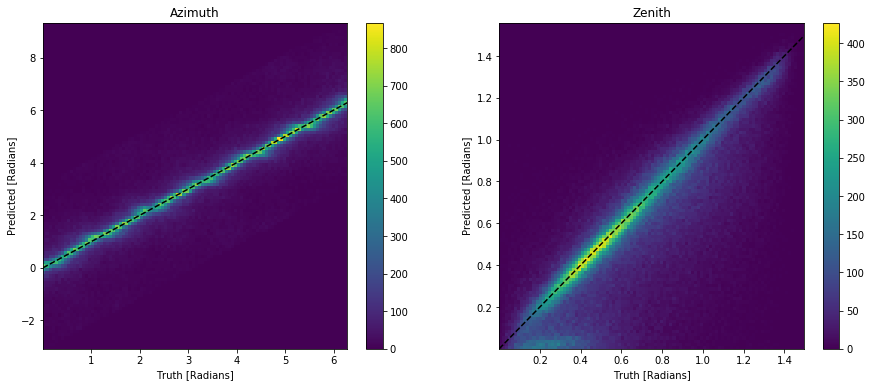

In [111]:
plot_bins = 100

fig, ax = plt.subplots(figsize=(15,6),ncols=2)

# ax[0].plot(true[:,0],az,'b.',alpha=0.05)
hist_az = ax[0].hist2d(true[:,0],az,plot_bins)
fig.colorbar(hist_az[3],ax=ax[0])

ax[0].plot([0,2*np.pi],[0,2*np.pi],'k--')


# ax[1].plot(true[:,1],ze,'b.',alpha=0.05)
hist_ze = ax[1].hist2d(true[:,1],ze,plot_bins)
fig.colorbar(hist_ze[3],ax=ax[1])

ax[1].plot([0,np.pi/2],[0,np.pi/2],'k--')

ax[0].set(title='Azimuth',xlabel='Truth [Radians]',ylabel='Predicted [Radians]')
ax[1].set(title='Zenith',xlabel='Truth [Radians]',ylabel='Predicted [Radians]')


# fig.savefig('figures/Reconstruction_angles.png')

[(-5, 5),
 Text(0.5, 0, '$( \\theta_{pred} - \\theta_{true} )/ \\sigma$'),
 Text(0.5, 1.0, '"Pull plot" of zenith')]

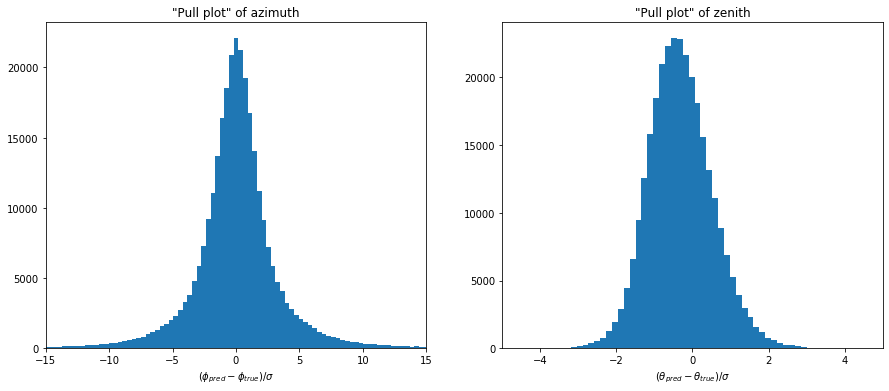

In [112]:
fig, ax = plt.subplots(figsize=(15,6),ncols=2)
ax[0].hist((az - true[:,0])/pred[:,2],bins=500);
ax[0].set(xlim=(-15,15),title='"Pull plot" of azimuth',xlabel = '$( \phi_{pred} - \phi_{true} )/ \sigma$')

ax[1].hist((ze - true[:,1])/pred[:,2],bins=200);
ax[1].set(xlim=(-5,5),title='"Pull plot" of zenith',xlabel = '$( \\theta_{pred} - \\theta_{true} )/ \sigma$')

# fig.savefig('figures/pull_plot_angles.png')

In [113]:
def omega(az_pred,ze_pred,az_truth,ze_truth):
        azm = az_pred
        azl = az_truth
        zem = ze_pred
        zel = ze_truth
        c1 = np.cos( zem - zel + azm - azl )
        c2 = np.cos( zem + zel + azm - azl )
        c3 = np.cos( zem - zel - azm + azl )
        c4 = np.cos( zem + zel - azm + azl )
        c5 = np.cos( zem - zel )
        c6 = np.cos( zem + zel )
        cos_diff_angle = 0.25*( c1 - c2 + c3 - c4) + 0.5*( c5 + c6 )
        return np.arccos(cos_diff_angle)

In [114]:
O = omega(pred[:,0],pred[:,1],true[:,0],true[:,1])

Text(0.5, 0, 'Radians')

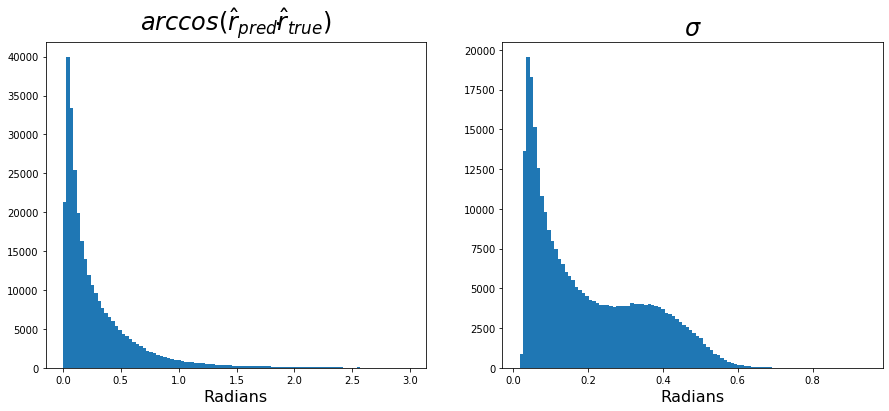

In [115]:
fig, ax = plt.subplots(figsize=(15,6),ncols = 2)
ax[0].hist(O,bins=100);
ax[0].set_title("$arccos(\hat{r}_{pred} \dot{} \hat{r}_{true})$",fontsize=24)
ax[0].set_xlabel("Radians",fontsize=16)

ax[1].hist(np.abs(pred[:,2]),bins=100);
ax[1].set_title("$\sigma$",fontsize=24)
ax[1].set_xlabel("Radians",fontsize=16)

# fig.savefig('figures/solid_angles_and_error_distribution.png')

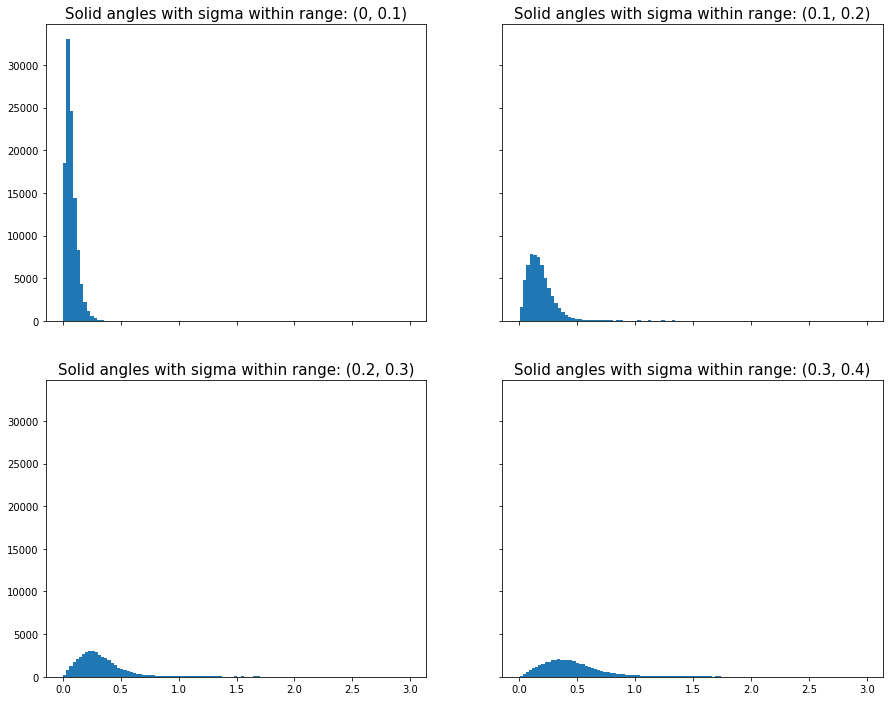

In [116]:
s_interval = (0,1)
def plot_range(s_interval,ax):
    mask = (np.abs(pred[:,2]) >= s_interval[0])&(np.abs(pred[:,2]) < s_interval[1])

    ax.hist(O[mask],bins=100);
    ax.set_title(f'Solid angles with sigma within range: {s_interval}',fontsize=15)
#     ax.set_yscale('log')
#     ax.set(title = f'{(O[mask] < s_interval[1]).sum()/mask.sum()}')

fig, ax = plt.subplots(figsize=(15,12),ncols=2,nrows=2,sharex=True,sharey=True)
ax = ax.flatten()
for i, s_interval in enumerate([(0,0.1),(0.1,0.2),(0.2,0.3),(0.3,0.4)]):
    plot_range(s_interval,ax[i])

# fig.savefig('figures/solid_angle_sigma_covariance_result.png')

[Text(0, 0.5, '$\\sigma$'),
 Text(0.5, 0, 'Solid angle [radians]'),
 Text(0.5, 1.0, 'Solid angle and $\\sigma$ correlation')]

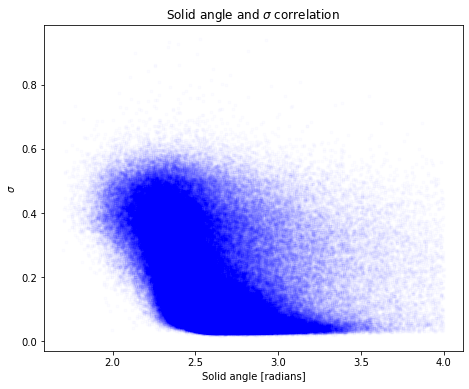

In [153]:
fig, ax = plt.subplots(figsize=(7.5,6))
# ax.plot(O,np.abs(pred[:,2]),'b.',alpha=0.01)
ax.plot(energy,np.abs(pred[:,2]),'b.',alpha=0.01)
ax.set(xlabel='Solid angle [radians]',ylabel='$\sigma$',title='Solid angle and $\sigma$ correlation')
# plt.savefig('figures/solid_angle_sigma_correlation.png')

# Moon recreation

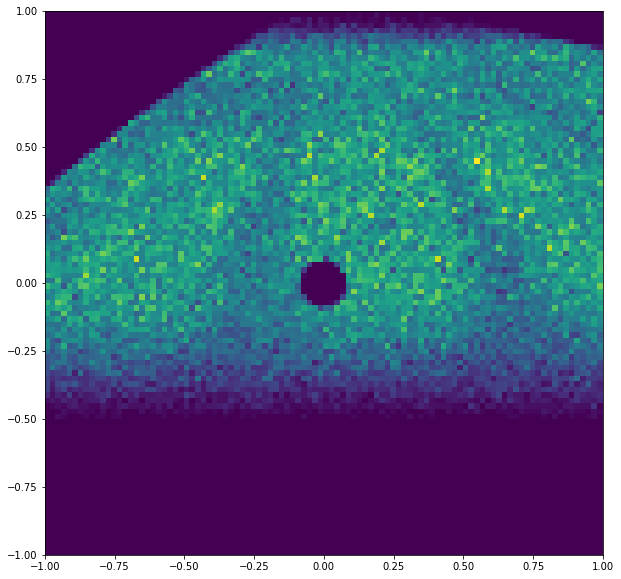

In [128]:
moon_pos = (1.5,0.5)
weights = np.ones(len(true))
weight_mask = (((true[:,0] - moon_pos[0])*np.cos(true[:,1]))**2 + (true[:,1] - moon_pos[1])**2) <= (5*np.pi/180)**2
weights[weight_mask] = 0

plot_bins = 100
plot_range = ((-1,1),(-1,1))#((-0.05,0.05),(-0.05,0.05))

fig, ax = plt.subplots(figsize=(10,10))
ax.hist2d((true[:,0] - moon_pos[0])*np.cos(true[:,1]),(true[:,1] - moon_pos[1]),plot_bins,plot_range,weights=weights);
# ax.hist2d((pred[:,0] - moon_pos[0])*np.cos(pred[:,1]),(pred[:,1] - moon_pos[1]),plot_bins,plot_range,weights=weights);

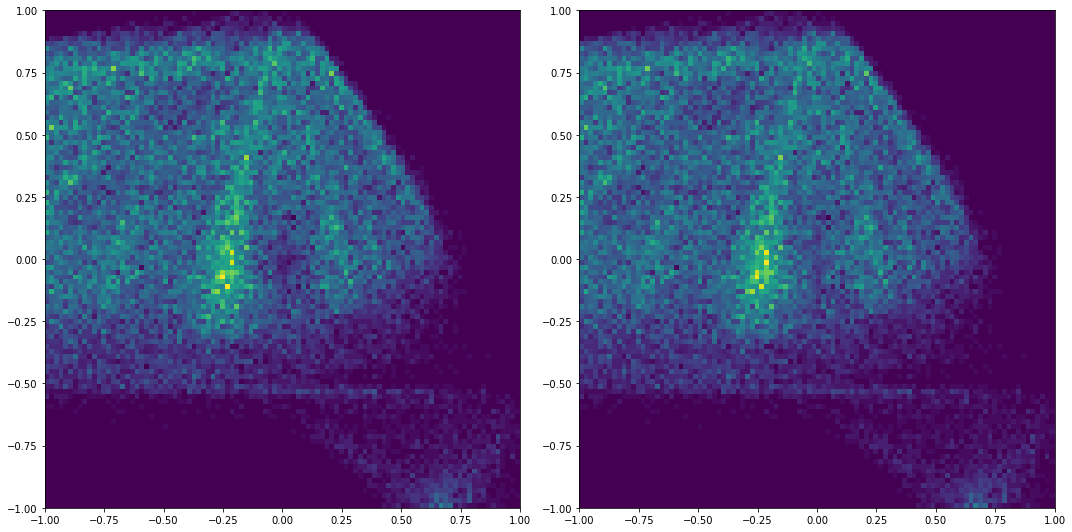

In [130]:
mask = np.abs(pred[:,2]) < 0.2
weights = np.ones(mask.sum())
weight_mask = (((true[mask,0] - moon_pos[0])*np.cos(true[mask,1]))**2 + (true[mask,1] - moon_pos[1])**2) <= (5*np.pi/180)**2
weights[weight_mask] = 0

plot_bins = 100
plot_range = ((-1,1),(-1,1))

fig, ax = plt.subplots(figsize=(15,7.5),ncols=2)
# ax.hist2d((true[:,0] - moon_pos[0])*np.cos(true[:,1]),(true[:,1] - moon_pos[1]),plot_bins,plot_range,weights=weights);
ax[0].hist2d((pred[mask,0] - moon_pos[0])*np.cos(pred[mask,1]),(pred[mask,1] - moon_pos[1]),plot_bins,plot_range,weights=weights);
ax[1].hist2d((pred[mask,0] - moon_pos[0])*np.cos(pred[mask,1]),(pred[mask,1] - moon_pos[1]),plot_bins,plot_range);
fig.tight_layout()

In [162]:
Q1, Q3 = np.quantile(O[pred[:,2] < np.quantile(pred[:,2],0.25)]*180/np.pi,(0.25,0.75))
(Q3-Q1)/1.349

def W(O,energy,bins=10):
    energy = energy.flatten()
    cuts = np.linspace(energy.min(),energy.max(),bins)
    IQR = []
    for i in range(bins-1):
        mask = (energy >= cuts[i]) & (energy <= cuts[i+1])
#         Q1, Q3 = np.quantile(O[mask],(0.25,0.75))
#         IQR.append((Q3-Q1)/1.349)
        U = np.quantile(O[mask],0.68)
        IQR.append(U)
        
    return IQR, 0.5*(cuts[1:] + cuts[:-1])

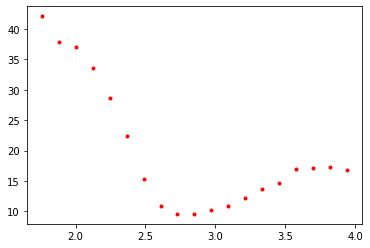

In [171]:
fig, ax = plt.subplots()

# IQR, E_x = W(O[mask]*180/np.pi,energy[mask],20)
# ax.plot(E_x,IQR,'b.')

IQR, E_x = W(O*180/np.pi,energy,20)
ax.plot(E_x,IQR,'r.')
# ax.set(ylim=(0,90))

# Looking into Rasmus' prediction: (seems there are no predictions in the file)

In [1]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import sqlite3

In [3]:
# event_nos = pd.read_pickle('datasets/event_nos_500k_muon_set1.pkl')

# db_path = "C:/Users/jv97/Desktop/github/Neutrino-Machine-Learning/predictions/Rasmus_predictions.db"

In [ ]:
# with sqlite3.connect(str(db_path)) as con:
    